In [1]:
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# ! pip3 install lightning mlflow
# ! pip3 install matplotlib

In [2]:
import os
import sys
import torch 
import pandas as pd
from numpy.lib.stride_tricks import sliding_window_view

import torch
from torch.utils.data import DataLoader, random_split
torch.set_float32_matmul_precision('high')

import mlflow.pytorch

import pytorch_lightning as pl
from lightning.pytorch.loggers import MLFlowLogger



In [3]:
path_to_package = os.path.abspath(os.path.join('..'))
if path_to_package not in sys.path:
    sys.path.append(path_to_package)
    
from src.utils.data_model_region import Region
from src.utils.feature_forcasting_dataset import FeatureForcastingDataset
from src.utils.feature_forcasting_dl_model import FeatureForecastingModel

In [4]:
# Global Constants
# Dataset
DATA_DIR_PATH = "./../data"
DATASET_PATH = f"{DATA_DIR_PATH}/PRSA2017_Data_20130301-20170228"
DATSET_PREPROCESSED_PATH = f"{DATA_DIR_PATH}/preprocessed"

# Model 
RANDOM_STATE = 1
PAST_WINDOW = 1*24
FUTURE_WINDOW = 1*24
BATCH_SIZE = 2048*16

DATE_COLUMNS = ['year','month','day','hour']
POLUTION_FEATURES = ["PM2.5","PM10","SO2","NO2","CO","O3"]
MODEL_INPUT_FEATURES = ["PM2.5","PM10","SO2","NO2","CO","O3"]




def get_preprocessed_dataset_path(region:Region, base_path:str=DATSET_PREPROCESSED_PATH)->str|None:
    """Get path to pre-processed dataset

    Args:
        region (Region): Specifies the region of the dataset
        base_path (str, optional): root dir of the dataset. Defaults to DATASET_PATH.

    Raises:
        ValueError: incorrect region provided

    Returns:
        str|None: returns the datset file path for the region or raises error
    """
    if type(region) == Region:
        return f"{base_path}/{region.value}.csv"
    else:
        raise ValueError("Unkown REGION name!!!")

# load datset

In [5]:
regions_df = {}

for region in Region:
    # read datset
    regions_df[region] = pd.read_csv(get_preprocessed_dataset_path(region=region), index_col=None)
    # generate date
    regions_df[region]['date'] = pd.to_datetime(regions_df[region][DATE_COLUMNS])
    regions_df[region].drop(DATE_COLUMNS, axis=1, inplace=True)
    # regions_df[region].drop('hour', axis=1, inplace=True)
    # # group by daily and average
    # regions_df[region] = regions_df[region].groupby('date').mean()
    # set datetime index 
    regions_df[region] = regions_df[region].set_index('date')

del region

In [6]:
regions_df[Region.AOTIZHONGXIN]

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,N,S,E,W
date,,,,,,,,,,,,,,,
2013-03-01 00:00:00,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,1.0,0.0,0.0,1.0
2013-03-01 01:00:00,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7,1.0,0.0,0.0,0.0
2013-03-01 02:00:00,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6,1.0,0.0,0.0,1.0
2013-03-01 03:00:00,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1,1.0,0.0,0.0,1.0
2013-03-01 04:00:00,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,2.4,1.0,0.0,0.0,1.0
2017-02-28 20:00:00,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,0.9,1.0,0.0,0.0,1.0
2017-02-28 21:00:00,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,1.1,1.0,0.0,0.0,1.0


In [7]:
def train_test_split(df:pd.DataFrame, feature:str, past_window:int, future_window:int, split_date:str='2016-03-01 00:00:00'):
    train_len = len(df[df.index < split_date]) 
    dataset_window = past_window + future_window
    sliding_window_dataset = sliding_window_view(df[feature], dataset_window)
    X_train = sliding_window_dataset[:train_len, :-future_window]
    X_test = sliding_window_dataset[train_len:, :-future_window]
    y_train = sliding_window_dataset[:train_len, -future_window:]
    y_test = sliding_window_dataset[train_len:, -future_window:]
    del sliding_window_dataset
    del dataset_window
    del train_len
    return X_train, X_test, y_train, y_test 

def get_test_feature_targets(df:pd.DataFrame, feature:str, split_date:str='2016-03-01 00:00:00'):
    return df[df.index >= split_date][feature].tolist()

# Deep Learning

In [8]:
mlflow.get_artifact_uri()

'file:///home/mutakabbir/Projects/federated-airquality-modeling/notebooks/mlruns/0/23cfc62f79e947d2a5073e8a770fe253/artifacts'

In [13]:
# Auto log all MLflow entities
mlflow.pytorch.autolog()
mlflow.set_tracking_uri("http://localhost:5001")
mlflow.set_experiment("AQL-MM-DL")

models = {}


# Train the models
with mlflow.start_run() as parent_run:
    parent_run_id = parent_run.info.run_id

    for feature in MODEL_INPUT_FEATURES:
        # Build Bataset
        dataset = FeatureForcastingDataset(regions_df[Region.AOTIZHONGXIN],feature, features=MODEL_INPUT_FEATURES, past_window=PAST_WINDOW,future_window=FUTURE_WINDOW)
        train_size = int(len(dataset) * 0.6)
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

        # build model
        models[feature] = FeatureForecastingModel(features=MODEL_INPUT_FEATURES, past_window=PAST_WINDOW,future_window=FUTURE_WINDOW, hidden_layer_size=2048, hidden_layers=30)

        # Create PyTorch Lightning trainer
        trainer = pl.Trainer(
            max_epochs=100,
            accelerator="gpu", 
            logger=False,
            enable_progress_bar=True,
            enable_checkpointing=False,
            devices=1  # Set the number of GPUs to use (change to 2, 3, etc., if available)
        )
        # log model into mlflow
        with mlflow.start_run(nested=True) as nested_run:
            nested_run_id = nested_run.info.run_id

            mlflow.log_param("feature", feature)
            # Train the model
            trainer.fit(models[feature], train_dataloaders=train_loader)
            # trainer.validate(models[feature], val_loader)



2023/05/30 18:53:32 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/05/30 18:53:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/mlflow/pytorch/_lightning_autolog.py:352: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.0.5 and 2.0.1.post0 and may not succeed with packages outside this range."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | layers   | Sequential        | 126 M 
1 | r2_score | R2Score         

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


2023/05/30 18:54:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/05/30 18:54:53 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Para

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


2023/05/30 18:56:19 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/05/30 18:56:22 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Para

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


2023/05/30 18:57:53 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/05/30 18:57:55 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Para

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


2023/05/30 18:59:30 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/05/30 18:59:32 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Para

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


2023/05/30 19:01:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/05/30 19:01:12 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Para

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


2023/05/30 19:03:02 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/05/30 19:03:04 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [ ]:
models

{'PM2.5': FeatureForecastingModel(
   (layers): Sequential(
     (0): Linear(in_features=6, out_features=2048, bias=True)
     (1): ReLU()
     (2): Linear(in_features=2048, out_features=2048, bias=True)
     (3): ReLU()
     (4): Linear(in_features=2048, out_features=2048, bias=True)
     (5): ReLU()
     (6): Linear(in_features=2048, out_features=2048, bias=True)
     (7): ReLU()
     (8): Linear(in_features=2048, out_features=1, bias=True)
   )
   (r2_score): R2Score()
   (mae): MeanAbsoluteError()
   (rmse): MeanSquaredError()
 ),
 'PM10': FeatureForecastingModel(
   (layers): Sequential(
     (0): Linear(in_features=6, out_features=2048, bias=True)
     (1): ReLU()
     (2): Linear(in_features=2048, out_features=2048, bias=True)
     (3): ReLU()
     (4): Linear(in_features=2048, out_features=2048, bias=True)
     (5): ReLU()
     (6): Linear(in_features=2048, out_features=2048, bias=True)
     (7): ReLU()
     (8): Linear(in_features=2048, out_features=1, bias=True)
   )
   (r2_s

In [ ]:
# get test data 
test_df = regions_df[Region.AOTIZHONGXIN][regions_df[Region.AOTIZHONGXIN].index > '2016-03-01 00:00:00']
test_df = (test_df - dataset.mean) / dataset.std

# get first input
X = test_df[MODEL_INPUT_FEATURES].iloc[0].to_list()
# X = torch.Tensor(X)

# generate target df
y_target_df = test_df[MODEL_INPUT_FEATURES]

# generate predictions
y_predict = [X]
while len(y_predict) < 24*60:#len(y_target_df) > len(y_predict):
    predictions = []
    for feature in MODEL_INPUT_FEATURES:
        models[feature].eval()
        input = torch.Tensor(y_predict[-1])
        feature_prediction = models[feature](input)[0].item()
        predictions.append(feature_prediction)
    y_predict.append(predictions)

<Axes: >

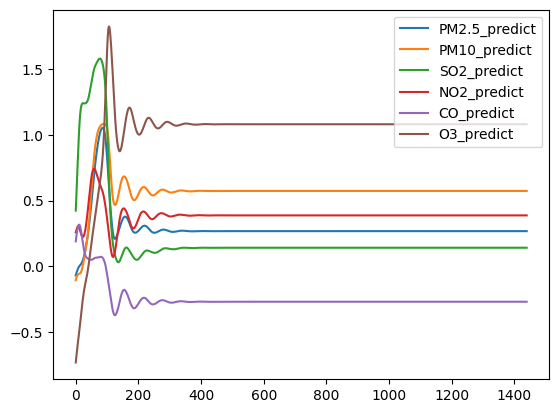

In [ ]:
pd.DataFrame(y_predict,columns=[f"{feature}_predict" for feature in MODEL_INPUT_FEATURES]).plot()

array([<Axes: >, <Axes: >], dtype=object)

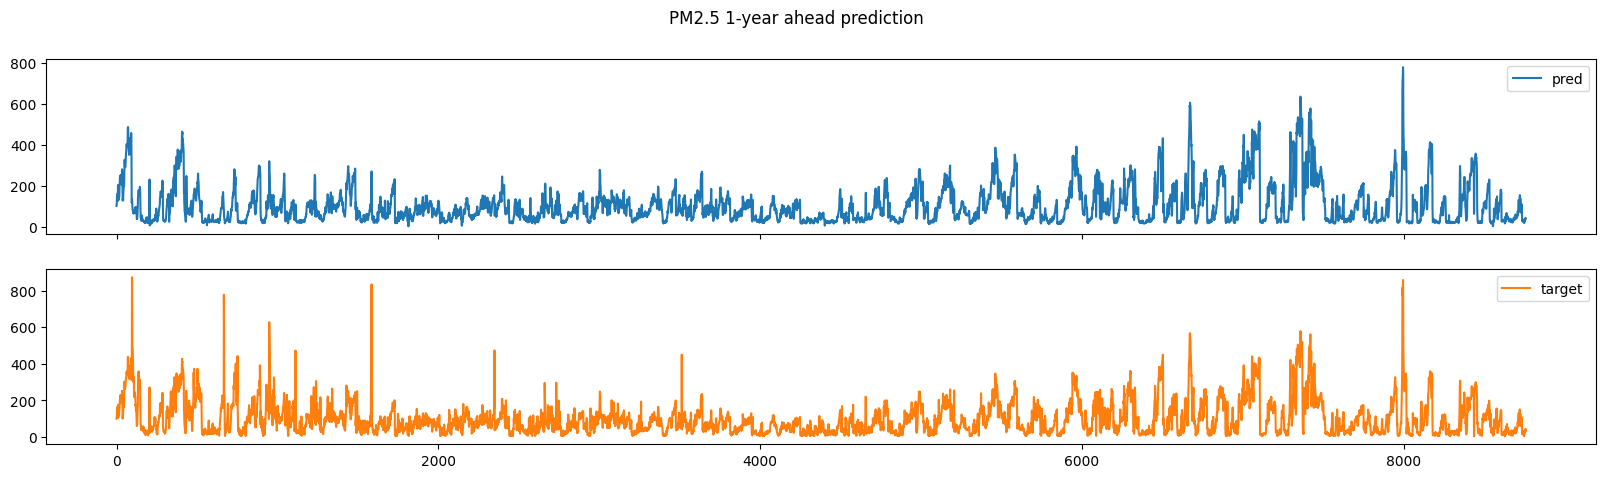

In [ ]:
prediction_df = pd.DataFrame({'pred':y_predict,'target':y_target})
prediction_df['pred'] = prediction_df['pred'] * dataset.std[feature] + dataset.mean[feature]
prediction_df['target'] = prediction_df['target'] * dataset.std[feature] + dataset.mean[feature]


prediction_df[:24*365].plot(figsize=(20,5),subplots=True, title="PM2.5 1-year ahead prediction")